In [1]:
cd /Users/vedanglad/Desktop/Top_Det/

In [2]:
#***********************************************************************************
# Master import
#***********************************************************************************

# Plot data in this window
%matplotlib inline

# Make the ipython cell width the size of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports some libraries
import glob
import sys
import time
import numpy as np
import os

# You might need to install pylab, matplotlib, scipy. They  comes with anaconda, amoung others. >> pip install anaconda
import pylab
from pylab import *
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp


# The current directory
cwd = os.getcwd() 

# The location where we will save figures
save_location = cwd + '/Figures/' 

if not os.path.isdir(save_location):
    os.mkdir(save_location)

# Fontsize and presets for matplotlib
font = { 'size':   24}
matplotlib.rc('font', **font)

plt.rc('text', usetex=True)
'''
# Allow it to use Latex notation
plt.rc('text', usetex=True)
'''

# Define your own colors for the plots, you can also use 'r' for red or 'g' for green.
mycolors = ['#c70039','#ff5733','#ff8d1a','#ffc300','#eddd53','#add45c','#57c785',
               '#00baad','#2a7b9b','#3d3d6b','#511849','#900c3f','#900c3f'] 

print('Imports complete ...')

Imports complete ...


In [3]:
# This class (CWClass) simply takes a CosmicWatch data file as fname, and let's the user select the bin size.
# It converts your file from the CW detector into something more useable.

class CWClass():
    def __init__(self,fname,bin_size = 60):
        self.fname = fname.split('/')[-1]
        self.bin_size = bin_size
        
        data = np.genfromtxt(fname = fname,
                                  delimiter = '\t',dtype = str,invalid_raise=False, comments='#')
        
        for i in range(len(data[:,5])):
            try:
                data[:,5][i] = float(data[:,5][i])
            except:
                data[:,5][i] = 0
        event_number = data[:,0].astype(np.float)
        print("event_number",event_number)
        rtc_time      = data[:,1] # The realtime clock date, if this is off, you need to upload the software.ino code to the detector. It will be updated.
        print("rtc_time",rtc_time)
        rtc_date      = data[:,2] # The realtime clock time, if this is off, you need to upload the software.ino code to the detector. It will be updated.
        print("rtc_date",rtc_date)
        timestamp = data[:,3].astype(np.float) # a more precise time, in ms.
        print("timestamp",timestamp)
        adc_H     = data[:,4].astype(np.float) 
        print("adc_H",adc_H)
        adc_L     = data[:,5].astype(np.float)
        print("adc_L",adc_L)
        sipm      = data[:,6].astype(np.float) # The calculated SiPM Peak voltage.
        print("sipm",sipm)
        temp      = data[:,7].astype(np.float) # The temperature, measured during each event
        print("temp",temp)
        pressure  = data[:,8].astype(np.float) # The pressure, measured during each event
        print("pressure",pressure)
        deadtime   = data[:,9].astype(np.float) # The detector deadtime since the last event.
        print("deadtime",deadtime)
        coincident= data[:,10].astype(np.float) # Was the event coincident?
        print("coincident",coincident)
        print(len([1 for element in coincident if element==1]))
        try:
            det_names = set(data[:,11])         # Was the event coincident?
            detector = data[:,11]      
            self.n_detector       = len(set(detName))
        except:
            pass
        
        
        self.timestamp        = np.asarray(timestamp) #-  min(np.asarray(timestamp))       # The absolute time of an event in seconds
        self.timestamp_s      = np.asarray(timestamp)/1000.
        self.SiPM             = sipm
        self.temperature      = temp
        self.pressure_hpa         = pressure/100.
        self.HGain_ADC        = adc_H
        self.LGain_ADC        = adc_L
        self.select_muons       = np.asarray(coincident == 1)
        self.select_non_muons       = np.invert(self.select_muons)
        self.detector = detector
        
        self.total_counts     = len(event_number)
        self.total_muons     = len(event_number[self.select_muons])
        self.event_deadtime_us  = deadtime
        self.event_deadtime_ms  = deadtime/1000.            # an array of the measured event deadtime in miliseconds
        self.event_deadtime_s   = self.event_deadtime_ms/1000.
        self.total_deadtime_s   = sum(self.event_deadtime_s)            # an array of the measured event deadtime in miliseconds
        self.livetime = max(self.timestamp_s)- self.total_deadtime_s

        try:
            mjd_time_stamp = []
            for i in range(len(rtc_date)):
                year  = int(rtc_date[i].split('/')[0])
                month = int(rtc_date[i].split('/')[1])
                day   = int(rtc_date[i].split('/')[2])
                hour  = int(rtc_time[i].split(':')[0])
                mins  = int(rtc_time[i].split(':')[1])
                sec   = int(np.floor(float(rtc_time[i].split(':')[2])))
                try:  
                    decimal = float('0.'+str(rtc_time[i].split('.')[-1]))
                except:
                    decimal = 0.0
                mjd_time_stamp.append(float(time.mktime((year, month, day, hour, mins, sec, 0, 0, 0)))+ decimal) 

            self.mjd_time_stamp     = np.asarray(mjd_time_stamp) -  min(np.asarray(mjd_time_stamp))       # modified julian date
        except:
            print('Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.')
            pass
        
        bins = range(0,int(max(self.timestamp_s)), self.bin_size)
        bin_deadtime, binEdges = np.histogram(self.timestamp_s, bins = bins,weights = self.event_deadtime_s)
        
        # binned data
        counts, binEdges       = np.histogram(self.timestamp_s, bins = bins)
        
        self.count_rate       = self.total_counts/self.livetime 
        self.count_rate_err   = np.sqrt(self.total_counts)/self.livetime 
        self.event_livetime_s = diff(np.append([0],self.timestamp_s)) - self.event_deadtime_s
        self.binned_counts     = counts
        self.binned_counts_err = np.sqrt(counts)
        self.binned_count_rate = counts/(bin_size-bin_deadtime)
        self.binned_count_rate_err = np.sqrt(counts)/(bin_size-bin_deadtime)
        print("--> "+self.fname)
        print('\tTotal Count rate: '+str(np.round(self.count_rate,4)) +' +/- '+ str(np.round(self.count_rate_err,4))+'Hz')
        
        
        # Coincident binned data
        counts_muons, binEdges        = np.histogram(self.timestamp_s[self.select_muons], bins = bins)
        self.count_rate_muons       = self.total_muons/self.livetime
        self.count_rate_err_muons   = np.sqrt(self.total_muons)/self.livetime         
        self.binned_counts_muons     = counts_muons
        self.binned_counts_err_muons = np.sqrt(counts_muons)
        self.binned_count_rate_muons = counts_muons/(bin_size-bin_deadtime)
        self.binned_count_rate_err_muons = np.sqrt(counts_muons)/(bin_size-bin_deadtime)
        print('\tCoincident Count rate: '+str(np.round(self.count_rate_muons,4)) +' +/- '+ str(np.round(self.count_rate_err_muons,4))+'Hz')
        
        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        self.bin_size          = bin_size
        self.binned_time_s     = bincenters
        self.binned_time_m     = bincenters/60.

In [4]:
# Let's input a test file. Bin size is in seconds, 600s = 10mins.
# # f1 = CWClass(cwd + "/FileC001.txt", bin_size = 30)
# f2 = CWClass(cwd + "/FileC002.txt", bin_size = 30)
f1 = CWClass(cwd + "/FileC004.txt", bin_size = 60)
# f1 = CWClass(cwd + "/FileC005.txt", bin_size = 60)
# f1 = CWClass(cwd + "/FileC006.txt", bin_size = 60)
# f1 = CWClass(cwd + "/FileC007.txt", bin_size = 60)
print("Average temperature during measurent: "+str(np.round(np.average(f1.temperature),2))+'C')
print("Average pressure during measurent: "+str(np.round(np.average(f1.pressure_hpa),2))+'hPa')
print("Max SiPM pulse during measurent: "+str(np.round(max(f1.SiPM),2))+'mV')

event_number [1.00000e+00 2.00000e+00 3.00000e+00 ... 1.17380e+05 1.17381e+05
 1.17382e+05]
rtc_time ['22:10:24' '22:10:30' '22:10:32' ... '0:31:39' '0:31:40' '0:31:43']
rtc_date ['10/4/2019 ' '10/4/2019 ' '10/4/2019 ' ... '11/4/2019 ' '11/4/2019 '
 '11/4/2019 ']
timestamp [4.550000e+02 6.637000e+03 8.648000e+03 ... 8.474650e+06 8.475905e+06
 8.478920e+06]
adc_H [340. 924. 964. ... 162. 967. 923.]
adc_L [  8. 133. 320. ...   7. 252. 140.]
sipm [11.55 36.38 60.46 ...  8.34 50.47 37.62]
temp [25.35 25.34 25.34 ... 29.56 29.56 29.57]
pressure [101709.94 101711.94 101711.88 ...  99843.64  99828.44  99811.07]
deadtime [ 50546. 359164. 102930. ...  52402.  54911. 153516.]
coincident [1. 0. 0. ... 0. 1. 0.]
23926
Windows 10 has a problem with mktime. Conversion to modified Julian date is left out.
--> FileC004.txt
	Total Count rate: 15.0772 +/- 0.044Hz
	Coincident Count rate: 3.0732 +/- 0.0199Hz
Average temperature during measurent: 28.17C
Average pressure during measurent: 787.4hPa
Max SiPM 

In [5]:
# This function will plot the rate as a function of time, given the bin_size you selected above.
# Time, count_rates, count_rates_err, color, lables -- these are lists of the data that you want to supper impose onto the figure.

def NPlot(time, # The binning times
             count_rates, # The measured count rate in each bin
             count_rates_err, # The statistical uncertainty in the count rate
             colors, # The color you want to use for the plot
             labels, # The label of the data
             xmin,xmax,ymin,ymax,autoscale =False, # setting up the axis
             figsize = [10,10],fontsize = 18, alpha = 0.9, # The figure aspect ratio, font size, alpha is the opacity.
             xscale = 'linear',yscale = 'linear', # Do you want a "linear" or "log" plot.
             xlabel = '',ylabel = '', # What do you want the axis labels to be?
             loc = 1,pdf_name='',title = ''): # loc is 1,2,3 or 4, and will change the location of the legend. pdf_name is the output fig name.
         
        f = plt.figure(figsize=(figsize[0], figsize[1])) 
        ax1 = f.add_subplot(111)

        for i in range(len(count_rates)):
            pylab.errorbar(time[i], 
                           count_rates[i],
                           xerr=0, yerr=count_rates_err[i],
                           fmt= 'ko',label = labels[i], linewidth = 2, ecolor = colors[i], markersize = 2)

        pylab.yscale(yscale, nonposy='clip')
        pylab.xscale(xscale, nonposx='clip')
        pylab.ylabel(ylabel)
        pylab.xlabel(xlabel)
        if autoscale:
            xmin = min(time[0])
            xmax = max(time[0])
            ymin = 0
            ymax = (max(count_rates[0])+max(count_rates_err[0]))*1.3
            for i in range(len(count_rates)):
                if min(time[i]) < xmin:
                    xmin = min(time[i])
                if max(time[i]) > xmax:                
                    xmax = max(time[i])
                if (max(count_rates[i])+max(count_rates_err[i]))*1.3 > ymax:
                    ymax = (max(count_rates[i])+max(count_rates_err[i]))*1.3
            pylab.axis([xmin, xmax, ymin,ymax])
        else:
            pylab.axis([xmin, xmax, ymin,ymax])
        
        pylab.legend(loc=loc, shadow=True,fontsize = 24,frameon = 0,fancybox = True)
        pylab.tight_layout()
        plt.title(title)
        if pdf_name != '':
            plt.savefig(save_location+ '/' + pdf_name, format='pdf',transparent =True)
            print("Saving: "+save_location+ '/' + pdf_name)
        pylab.show()

<ipython-input-5-c65ec62d29a4>:24: MatplotlibDeprecationWarning: ScaleBase got an unexpected keyword argument 'nonposy'. This will become an error in 3.4.
  pylab.yscale(yscale, nonposy='clip')
<ipython-input-5-c65ec62d29a4>:25: MatplotlibDeprecationWarning: ScaleBase got an unexpected keyword argument 'nonposx'. This will become an error in 3.4.
  pylab.xscale(xscale, nonposx='clip')


Saving: /Users/vedanglad/Desktop/Top_Det/Figures//Rate_measurement.pdf


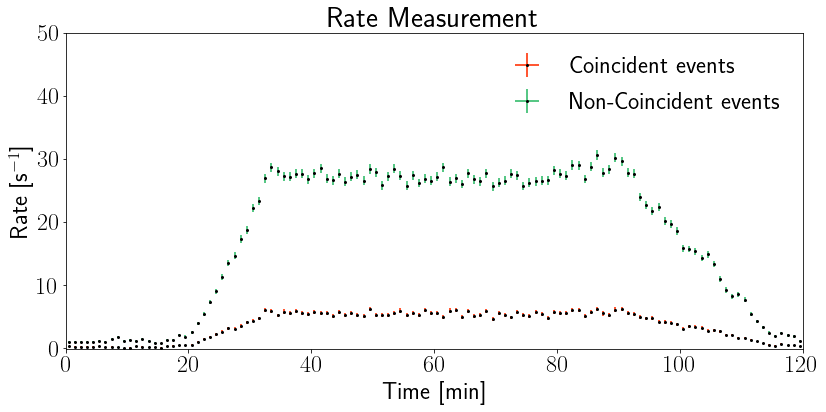

In [6]:
# Note, the number of entries in the time list, must equal the number of entries in count_rates, count_rates_err, colors, and labels.
NPlot(time = [f1.binned_time_m,f1.binned_time_m], 
         count_rates = [f1.binned_count_rate_muons,f1.binned_count_rate],
         count_rates_err = [f1.binned_count_rate_err_muons,f1.binned_count_rate_err],
         colors =[mycolors[1],mycolors[6]],
         labels = [r'Coincident events',r'Non-Coincident events'],
         autoscale=False,
         xmin = 0,xmax = 120,ymin = -0.1,ymax = 50,
         figsize = [12,6],fontsize = 20,alpha = 1,
         xscale = 'linear',yscale = 'linear',
         xlabel = 'Time [min]',ylabel = r'Rate [s$^{-1}$]',
         loc = 1,pdf_name='Rate_measurement.pdf',title = 'Rate Measurement')

# Play around with the settings.
# If the labelling looks small, rerun the master import a few cells above.

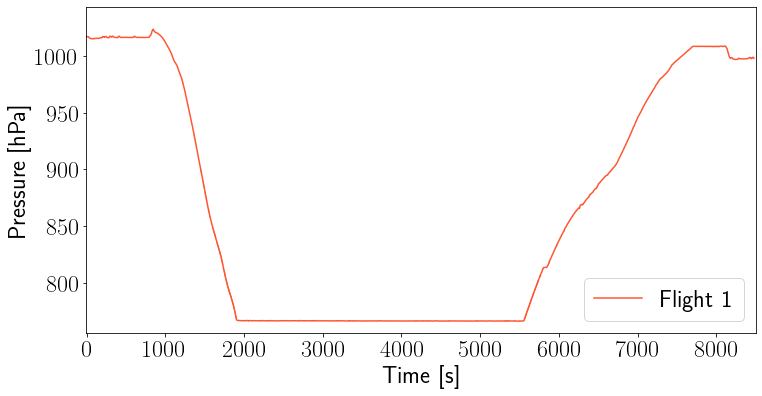

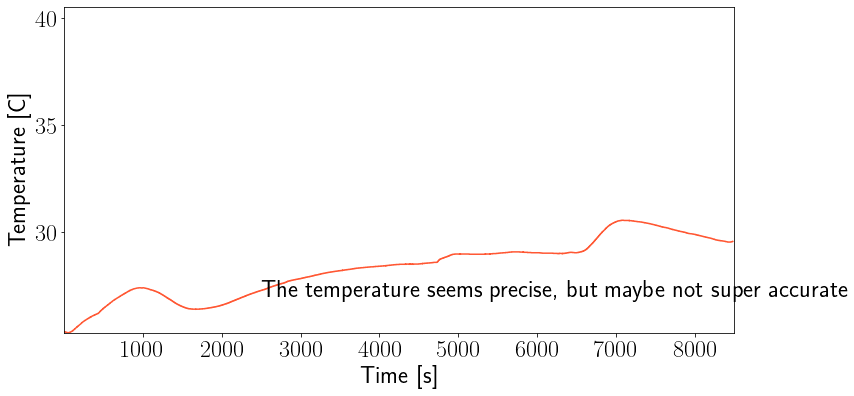

In [7]:
figsize = [12,6]
f = plt.figure(figsize=(figsize[0], figsize[1])) 
ax1 = f.add_subplot(111)
pylab.ylabel('Pressure [hPa]')
pylab.xlabel("Time [s]")
pylab.axis([min(f1.timestamp_s)-10, max(f1.timestamp_s)+20, min(f1.pressure_hpa)-10,max(f1.pressure_hpa)+20])
plt.plot(f1.timestamp_s,f1.pressure_hpa,color = mycolors[1], label="Flight 1")
# plt.plot(f1.timestamp_s,f.pressure_hpa,color = mycolors[2], label="Flight 2 ")
# plt.plot(f1.timestamp_s,f3.pressure_hpa,color = mycolors[3], label="Flight 3 ")
# plt.plot(f1.timestamp_s,f4.pressure_hpa,color = mycolors[4], label="Flight 4 ")
plt.savefig(save_location+ '/Pressure.pdf', format='pdf',transparent =True)
plt.legend()
pylab.show()

f = plt.figure(figsize=(figsize[0], figsize[1])) 
ax1 = f.add_subplot(111)
pylab.ylabel('Temperature [C]')
plt.text(2500, 27, r'The temperature seems precise, but maybe not super accurate')
pylab.xlabel("Time [s]")
pylab.axis([min(f1.timestamp_s), max(f1.timestamp_s)+10, min(f1.temperature),max(f1.temperature)+10])
plt.plot(f1.timestamp_s,f1.temperature,color = mycolors[1])
# plt.plot(f2.timestamp_s,f2.temperature,color = mycolors[2])
# plt.plot(f3.timestamp_s,f3.temperature,color = mycolors[3])
# plt.plot(f4.timestamp_s,f4.temperature,color = mycolors[4])
plt.savefig(save_location+ '/Temperature.pdf', format='pdf',transparent =True)
pylab.show()

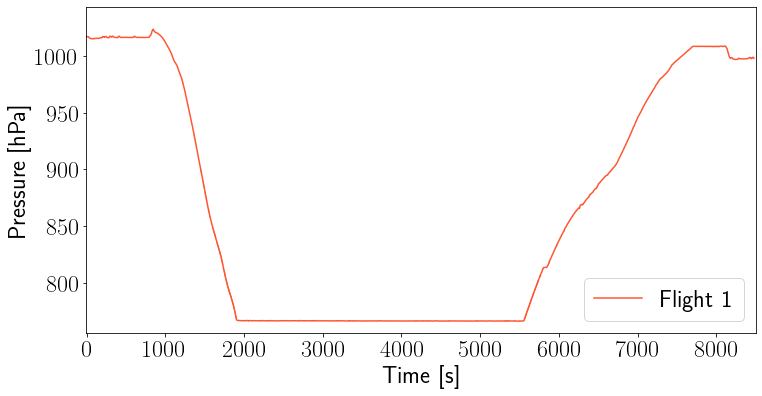

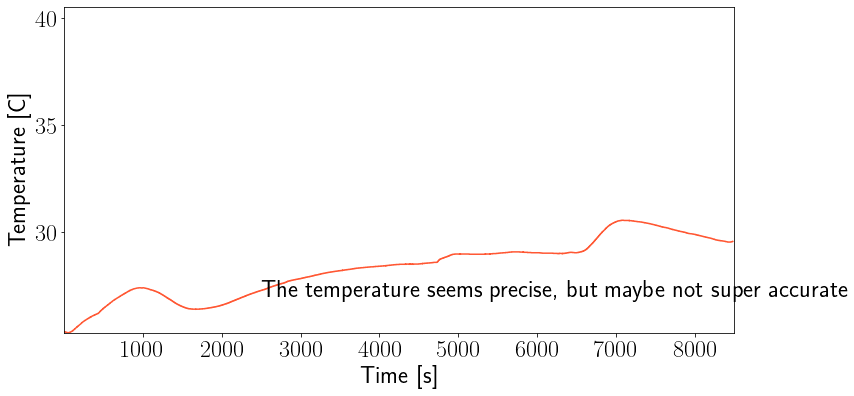

In [8]:
figsize = [12,6]
f = plt.figure(figsize=(figsize[0], figsize[1])) 
ax1 = f.add_subplot(111)
pylab.ylabel('Pressure [hPa]')
pylab.xlabel("Time [s]")
pylab.axis([min(f1.timestamp_s)-10, max(f1.timestamp_s)+20, min(f1.pressure_hpa)-10,max(f1.pressure_hpa)+20])
plt.plot(f1.timestamp_s,f1.pressure_hpa,color = mycolors[1], label="Flight 1")
# plt.plot(f2.timestamp_s,f2.pressure_hpa,color = mycolors[2], label="Flight 2 ")
# plt.plot(f3.timestamp_s,f3.pressure_hpa,color = mycolors[3], label="Flight 3 ")
# plt.plot(f4.timestamp_s,f4.pressure_hpa,color = mycolors[4], label="Flight 4 ")
plt.savefig(save_location+ '/Pressure.pdf', format='pdf',transparent =True)
plt.legend()
pylab.show()

f = plt.figure(figsize=(figsize[0], figsize[1])) 
ax1 = f.add_subplot(111)
pylab.ylabel('Temperature [C]')
plt.text(2500, 27, r'The temperature seems precise, but maybe not super accurate')
pylab.xlabel("Time [s]")
pylab.axis([min(f1.timestamp_s), max(f1.timestamp_s)+10, min(f1.temperature),max(f1.temperature)+10])
plt.plot(f1.timestamp_s,f1.temperature,color = mycolors[1])
# plt.plot(f2.timestamp_s,f2.temperature,color = mycolors[2])
# plt.plot(f3.timestamp_s,f3.temperature,color = mycolors[3])
# plt.plot(f4.timestamp_s,f4.temperature,color = mycolors[4])
plt.savefig(save_location+ '/Temperature.pdf', format='pdf',transparent =True)
pylab.show()

In [9]:
# Maybe you want to histogram the data, rather than look at rate as a function of time. 
# The following does this and includes the statistical errors in the bins.

def plusSTD(n,array):
    xh = np.add(n,np.sqrt(np.abs(array)))
    return xh

def subSTD(n,array):
    xl = np.subtract(n,np.sqrt(np.abs(array)))
    return xl

def fill_between_steps(x, y1, y2=0, h_align='mid', ax=None,lw=2, **kwargs):
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:]
    # Now: the average x binwidth
    xstep = sp.repeat((x[1:] - x[:-1]), 2)
    xstep = sp.concatenate(([xstep[0]], xstep, [xstep[-1]]))
    # Now: add one step at end of row.
    xx = sp.append(xx, xx.max() + xstep[-1])

    # Make it possible to chenge step alignment.
    if h_align == 'mid':
        xx -= xstep / 2.
    elif h_align == 'right':
        xx -= xstep

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == sp.ndarray:
        y2 = y2.repeat(2)#[:-1]

    # now to the plotting part:
    ax.fill_between(xx, y1, y2=y2,lw=lw, **kwargs)
    return ax


def NHist(data,
         colors,
         labels,
         xmin,xmax,ymin,ymax,
         normalize=False,figsize = [10,10],fontsize = 18,nbins = 101, alpha = 0.9,
         xscale = 'log',yscale = 'log',
         xlabel = '',ylabel='',
         loc = 1,pdf_name='',lw=2, title=''):
        
    fig = plt.figure(figsize=(figsize[0], figsize[1])) 
    ax1 = fig.add_subplot(111)

    if xscale == 'log':
        bins = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
    if xscale == 'linear':
        bins = np.linspace(xmin,xmax,nbins)

    for i in range(len(data)):
        counts,binEdges = np.histogram(data[i][~np.isnan(data[i])],bins = bins,weights = np.ones(len(data[i])),range= (200,1024))

        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        sumWeightsSqrd, binEdges = np.histogram(data[i][~np.isnan(data[i])], bins = bins, weights = np.power(np.ones(len(data[i])),2),range= (200,1024))

        if normalize:
            fill_between_steps(bincenters, plusSTD(counts,sumWeightsSqrd)/sum(counts),subSTD(counts,sumWeightsSqrd)/sum(counts),  color = colors[i],alpha = alpha,lw=lw)
        else:
            fill_between_steps(bincenters, plusSTD(counts,sumWeightsSqrd),subSTD(counts,sumWeightsSqrd),  color = colors[i],alpha = alpha,lw=lw)
        pylab.plot([1e14,1e14], label = labels[i],color = colors[i],alpha = alpha,linewidth = 2)

    pylab.yscale(yscale, nonposy='clip')
    pylab.xscale(xscale, nonposx='clip')
    pylab.grid(b=True, which='major', color='k', alpha = 0.1,linestyle='-')
    pylab.grid(b=True, which='minor', color='k',alpha = .05,  linestyle='-')
    pylab.legend(fontsize=fontsize-2,loc = loc,  fancybox = True,frameon=True)
    pylab.ylabel(ylabel,size=fontsize)
    pylab.xlabel(xlabel, labelpad=20,size=fontsize)
    pylab.axis([xmin, xmax, ymin,ymax])
    plt.title(title,fontsize=fontsize)
    pylab.tight_layout()
    if pdf_name != '':
        plt.savefig(save_location+ '/' + pdf_name, format='pdf',transparent =True)
        print("Saving: "+save_location+ '/' + pdf_name)
    pylab.show()
    #example of accesing the data from the class

<ipython-input-9-81c142cab82c>:19: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
  xstep = sp.repeat((x[1:] - x[:-1]), 2)
<ipython-input-9-81c142cab82c>:20: DeprecationWarning: scipy.concatenate is deprecated and will be removed in SciPy 2.0.0, use numpy.concatenate instead
  xstep = sp.concatenate(([xstep[0]], xstep, [xstep[-1]]))
<ipython-input-9-81c142cab82c>:22: DeprecationWarning: scipy.append is deprecated and will be removed in SciPy 2.0.0, use numpy.append instead
  xx = sp.append(xx, xx.max() + xstep[-1])
<ipython-input-9-81c142cab82c>:69: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pylab.yscale(yscale, nonposy='clip')
<ipython-input-9-81c142cab82c>:70: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; 

Saving: /Users/vedanglad/Desktop/Top_Det/Figures//Multiple_histgrams.pdf


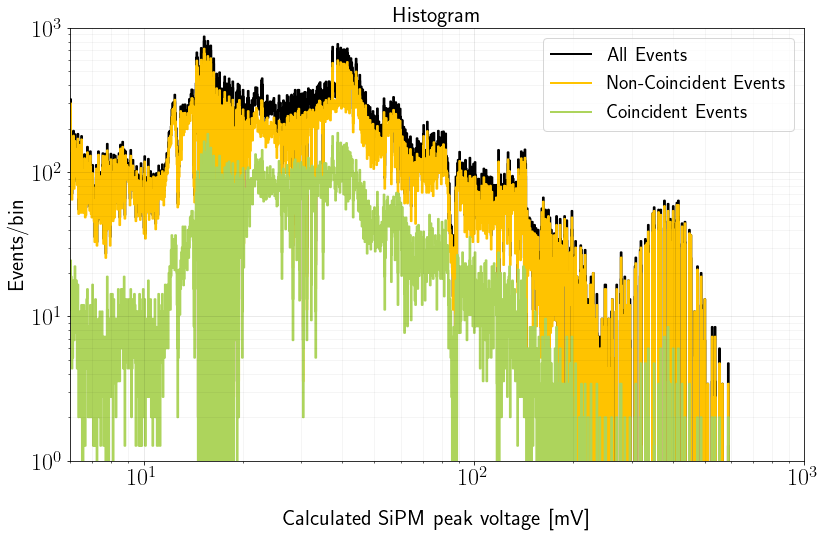

In [10]:
# f1.SiPM is an array of SiPM values from file 1.
# [f1.select_non_muons] is an array of Trues and Falses. 
#    This is called a mask. When you multiply a numpy array by a mask, 
#    it removes all the elements that correspond to False. In this case, 
#    f1.SiPM is all the events
#    f1.SiPM[f1.select_non_muons] is an array of the events that are not tagged as coincident events
#    f1.SiPM[f1.select_muons] is an array of the events that are tagged as coincident events

NHist(data = [f1.SiPM, f1.SiPM[f1.select_non_muons],f1.SiPM[f1.select_muons]], 
    colors = ['k', mycolors[3], mycolors[5]], # you can also use standard colors like 'red', 'black' etc
    labels = ['All Events','Non-Coincident Events','Coincident Events'],
    figsize = [12,8],
    normalize = False,
    fontsize = 22,
    xmin = 6, xmax = 1000,ymin = 1,ymax =1000,
    nbins =  1001, alpha = 1, lw=2,
    xscale = 'log',yscale = 'log',# you can type linear or log
    xlabel = 'Calculated SiPM peak voltage [mV]',
    ylabel = "Events/bin",
    title = 'Histogram',
    loc = 1, pdf_name='Multiple_histgrams.pdf')

# This plot is telling you that SiPM peak voltages above ~40mV are dominated by muons rather than backgrounds.
# That is, you can see that the green histgoram is ~ larger than the yellow, above ~40mV.
# In the low SiPM peak voltages, you can see those are primarily non-coincident events, which are primarily background gamma radiation.
